# Lab 5:  RC Circuit Analysis

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Capacitor-Resistor Combination 1

In each phase of this experiment, a different combination of capactior and resistor, in a series circuit, was used.  The theory is as follows:

When the switch is closed, thus defining $t=0$, the voltage across the capacitor will be given by:

$
\begin{equation}
V(t) = V_{source}(1 - e^{-\frac{t}{RC}})
\end{equation}
$

The current through the circuit, defined according to $i_C = C\frac{dV_C}{dt}$, is:

$
\begin{equation}
i(t) = \frac{V_{source}}{R}e^{-\frac{t}{RC}}
\end{equation}
$

The charge on the capacitor, defined by $Q = \int_0^t i(t)dt$, is given by:

$
\begin{equation}
Q(t) = C V_{source}(1-e^{-\frac{t}{RC}})
\end{equation}
$


In [18]:
# Create a Pandas DataFrame with data for part 1

df1 = pd.read_csv("Experiment5_Cohen.csv")

df1_iv = (df1.copy()).drop(df1.columns[3], axis=1).dropna()
df1_q = (df1.copy()).drop(df1.columns[2], axis=1)
df1_q = (df1_q.copy()).drop(df1_q.columns[1], axis=1).dropna()

In [19]:
df1_iv = df1_iv.set_axis(['t', 'v', 'i'], axis=1, inplace=False)
df1_q = df1_q.set_axis(['t', 'q'], axis=1, inplace=False)

df1_iv['di']=0.000001
df1_iv['dv']=0.001
df1_iv['dt']=0.0001

df1_q['dt']=0.0001
df1_q['dq']=1E-8

#pd.set_option('display.max_rows', None)
df1_iv

,t,v,i,di,dv,dt
0,0.0000,1.038,-0.000052,0.000001,0.001,0.0001
2,0.0005,1.039,-0.000264,0.000001,0.001,0.0001
4,0.0010,1.038,-0.000131,0.000001,0.001,0.0001
6,0.0020,1.037,-0.000308,0.000001,0.001,0.0001
8,0.0020,1.038,-0.000267,0.000001,0.001,0.0001
...,...,...,...,...,...,...
47800,11.9500,10.184,-0.000748,0.000001,0.001,0.0001
47802,11.9510,10.185,-0.000832,0.000001,0.001,0.0001
47804,11.9510,10.185,-0.000859,0.000001,0.001,0.0001
47806,11.9520,10.187,-0.000850,0.000001,0.001,0.0001


Our first task is to define the $t=0$ point.  We should graph the raw data, for voltage vs. time, and use this plot to decide on the fit region.

<ErrorbarContainer object of 3 artists>

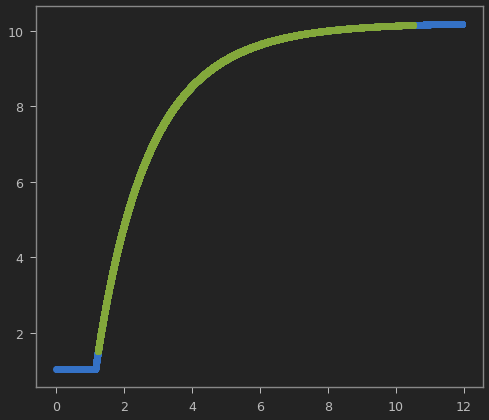

In [21]:
xi = df1_iv['t']
yi = df1_iv['v']
sigmaxi = df1_iv['dt']
sigmayi = df1_iv['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)

tlow = 1.220
thigh = 10.500

df1_iv_select = df1_iv[(df1_iv['t']>tlow) & (df1_iv['t']<thigh)]
xi = df1_iv_select['t']
yi = df1_iv_select['v']
sigmaxi = df1_iv_select['dt']
sigmayi = df1_iv_select['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)



Beta: [10.14044771  0.92341825  1.65215911]
Beta Std Error: [0.00039989 0.00029167 0.00043062]
Beta Covariance: [[ 1.70025807e-10 -5.11754052e-11  1.30041157e-10]
 [-5.11754052e-11  9.04556687e-11 -1.08420545e-10]
 [ 1.30041157e-10 -1.08420545e-10  1.97165680e-10]]
Residual Variance: 940.5033393914069
Inverse Condition #: 0.14715924710756192
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (10.140447709 +/- 0.000399887) (1 - EXP(-(X - (0.923418249 +/- 0.000291674))/(1.652159109 +/- 0.000430622)))


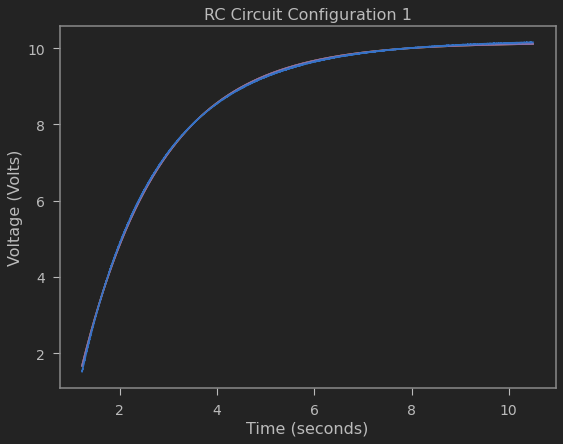

In [22]:
from scipy.odr import *

def fitfunction(B, x):
    '''Exponential function y = B[0](1 - e^(-(x-B[1])/B[2]))'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*(1.0-np.exp(-(x-B[1])/B[2]))

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[10.00, tlow, 2.2]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) (1 - EXP(-(X - (%0.9f +/- %0.9f))/(%0.9f +/- %0.9f)))" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Volts)')
plt.title('RC Circuit Configuration 1')
plt.show()

In [10]:
# Create a Pandas DataFrame with data for part 2

df2 = pd.read_csv("exp5_data_part2.csv")

df2_iv = (df2.copy()).drop(df2.columns[3], axis=1).dropna()
df2_q = (df2.copy()).drop(df2.columns[2], axis=1)
df2_q = (df2_q.copy()).drop(df2_q.columns[1], axis=1).dropna()

In [11]:
df2_iv = df2_iv.set_axis(['t', 'v', 'i'], axis=1, inplace=False)
df2_q = df2_q.set_axis(['t', 'q'], axis=1, inplace=False)

df2_iv['di']=0.000001
df2_iv['dv']=0.001
df2_iv['dt']=0.0001

df2_q['dt']=0.0001
df2_q['dq']=1E-8

#pd.set_option('display.max_rows', None)
df2_iv

,t,v,i,di,dv,dt
0,0.0000,0.030,0.000094,0.000001,0.001,0.0001
2,0.0005,-0.005,0.000016,0.000001,0.001,0.0001
4,0.0010,-0.004,0.000055,0.000001,0.001,0.0001
6,0.0020,-0.005,0.000079,0.000001,0.001,0.0001
8,0.0020,-0.004,0.000113,0.000001,0.001,0.0001
...,...,...,...,...,...,...
41876,10.4690,10.001,0.002000,0.000001,0.001,0.0001
41878,10.4700,10.002,0.002000,0.000001,0.001,0.0001
41880,10.4700,10.001,0.002000,0.000001,0.001,0.0001
41882,10.4710,10.001,0.002000,0.000001,0.001,0.0001


<ErrorbarContainer object of 3 artists>

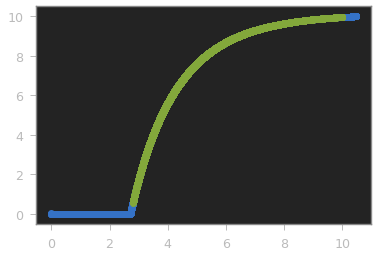

In [15]:
xi = df2_iv['t']
yi = df2_iv['v']
sigmaxi = df2_iv['dt']
sigmayi = df2_iv['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)

tlow = 2.800
thigh = 10.000

df2_iv_select = df2_iv[(df2_iv['t']>tlow) & (df2_iv['t']<thigh)]
xi = df2_iv_select['t']
yi = df2_iv_select['v']
sigmaxi = df2_iv_select['dt']
sigmayi = df2_iv_select['dv']

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

Beta: [10.02839766  2.67816935  1.63175141]
Beta Std Error: [0.00059001 0.00025331 0.00047389]
Beta Covariance: [[ 3.53944463e-10 -6.78877656e-11  2.27670471e-10]
 [-6.78877656e-11  6.52434946e-11 -9.36089260e-11]
 [ 2.27670471e-10 -9.36089260e-11  2.28335213e-10]]
Residual Variance: 983.5213699600832
Inverse Condition #: 0.156288993608899
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (10.028397660 +/- 0.000590010) (1 - EXP(-(X - (2.678169345 +/- 0.000253315))/(1.631751405 +/- 0.000473891)))


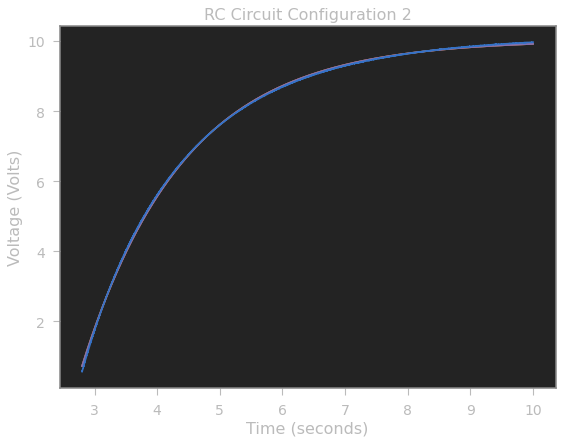

In [16]:
from scipy.odr import *

def fitfunction(B, x):
    '''Exponential function y = B[0](1 - e^(-(x-B[1])/B[2]))'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*(1.0-np.exp(-(x-B[1])/B[2]))

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sx=sigmaxi, sy=sigmayi) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[10.00, tlow, 2.2]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower 99% "Confidence Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(pi,xi) for pi in ps])

lower = np.percentile(ysample,0.5,axis=0)
upper = np.percentile(ysample,99.5,axis=0)
middle = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) (1 - EXP(-(X - (%0.9f +/- %0.9f))/(%0.9f +/- %0.9f)))" % (popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

plt.figure(figsize=(8, 6), dpi=80)

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Volts)')
plt.title('RC Circuit Configuration 2')
plt.show()